In [ ]:
!wget https://www.lamsade.dauphine.fr/~cazenave/project2026.zip
!unzip project2026.zip
!ls -l

!git clone https://github.com/ArturoBenedettiMichelangeli/GO_Neural_Network.git

--2026-02-17 16:26:21--  https://www.lamsade.dauphine.fr/~cazenave/project2026.zip
Resolving www.lamsade.dauphine.fr (www.lamsade.dauphine.fr)... 193.48.71.250
Connecting to www.lamsade.dauphine.fr (www.lamsade.dauphine.fr)|193.48.71.250|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 138578548 (132M) [application/zip]
Saving to: ‘project2026.zip’

project2026.zip     100%[===================>] 132.16M  56.6MB/s    in 2.3s    

2026-02-17 16:26:24 (56.6 MB/s) - ‘project2026.zip’ saved [138578548/138578548]

Archive:  project2026.zip
  inflating: games.data              
  inflating: golois.cpython-312-x86_64-linux-gnu.so  
total 665404
-rw-r--r-- 1 root root 542497580 Oct  7  2022 games.data
-rwxr-xr-x 1 root root    284672 Oct  1 15:09 golois.cpython-312-x86_64-linux-gnu.so
-rw-r--r-- 1 root root 138578548 Oct  1 20:02 project2026.zip
drwxr-xr-x 1 root root      4096 Feb  6 14:31 sample_data
Cloning into 'GO_Neural_Network'...
remote: Enumerating objects: 64,

##Architectures/techniques testées :

* reseaux residuels (resnet)
* reseaux residuels + attention en sortie (SE-post-block)
* meme chose + cosine annealing
* avec/sans distillation
* Réseau MobileNet avec CosineAnnealing et Swish Activation dans le bloc résiduel

###ResNet

Chargement du set de validation séparé...
Epoch 1/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - loss: 6.1178 - policy_categorical_accuracy: 0.0041 - policy_loss: 5.9073 - value_loss: 0.2013 - value_mae: 0.3579
Epoch 2/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.0062 - policy_categorical_accuracy: 0.0071 - policy_loss: 5.8416 - value_loss: 0.1554 - value_mae: 0.3181
Epoch 3/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.7900 - policy_categorical_accuracy: 0.0141 - policy_loss: 5.6403 - value_loss: 0.1405 - value_mae: 0.3101
Epoch 4/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.4680 - policy_categorical_accuracy: 0.0271 - policy_loss: 5.3273 - value_loss: 0.1316 - value_mae: 0.3011
Epoch 5/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.2141 - policy_categorical_accuracy: 0.0398 - policy_loss: 5.0794 - value_loss: 0.1257 - value_mae: 0.2957
Epoch 6/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.0360 - policy_categorical_accuracy: 0.0611 - policy_los

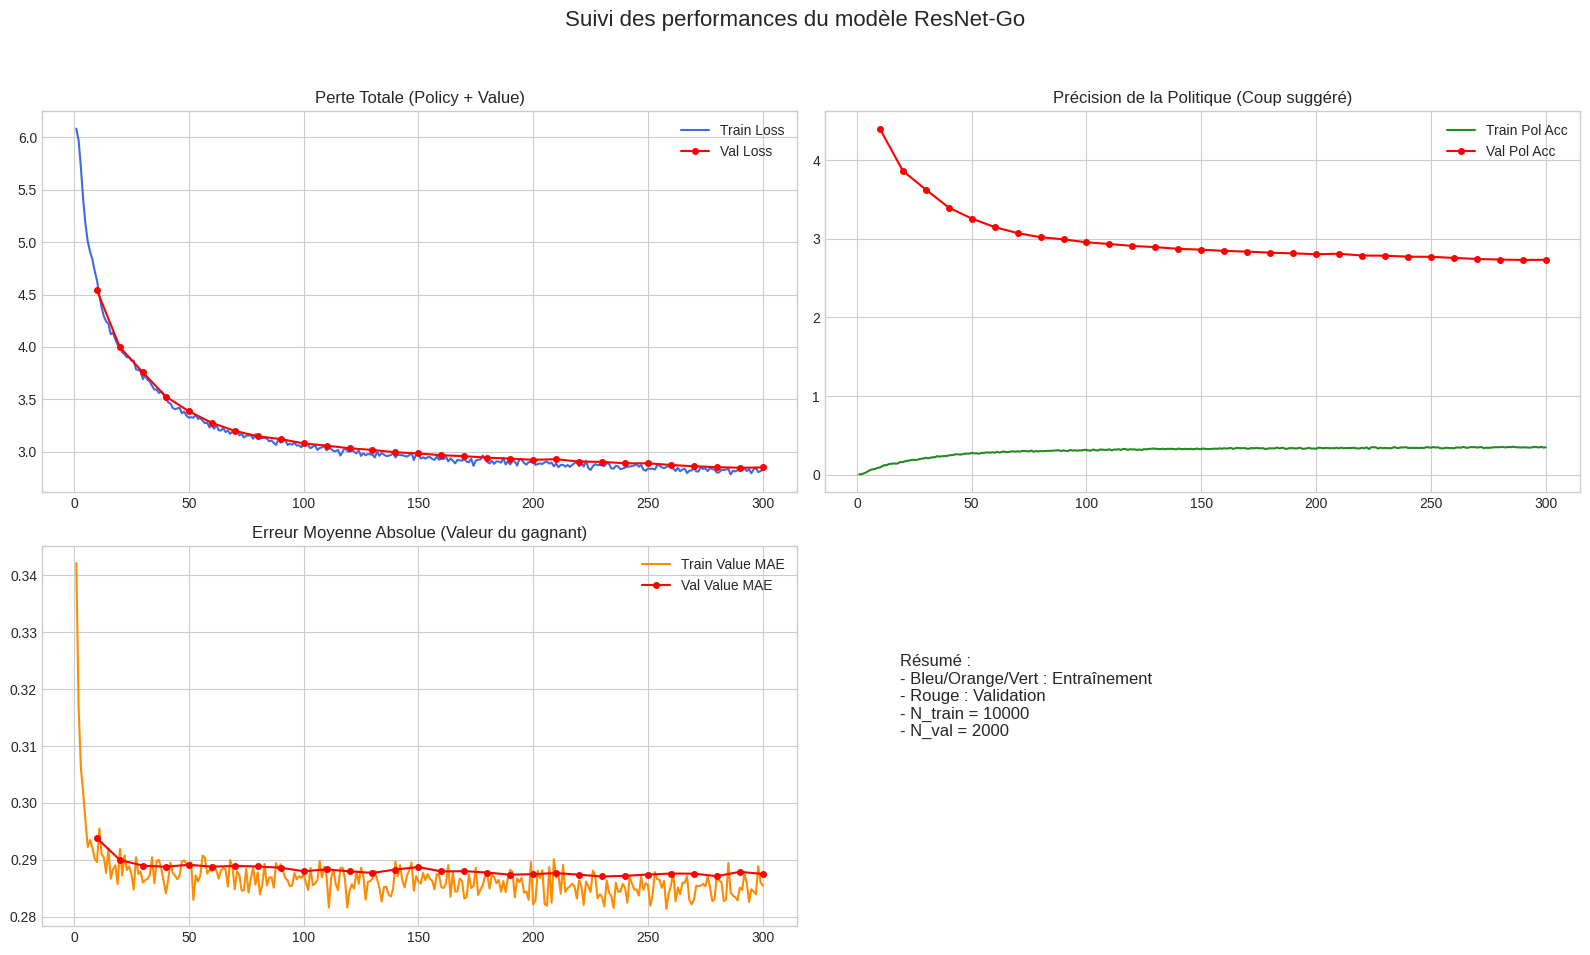

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
from tensorflow.keras import layers, regularizers, losses
import gc
import matplotlib.pyplot as plt
import golois

tf.keras.backend.clear_session(free_memory=True)

# --- Paramètres ---
planes, moves, N, epochs, batch, filters = 31, 361, 10000, 300, 128, 32
N_val = 2000

# --- Préparation des données ---
input_data = np.zeros((N, 19, 19, planes), dtype='float32')
policy = np.zeros((N, moves), dtype='float32')
value = np.zeros((N,), dtype='float32')
end = np.zeros((N, 19, 19, 2), dtype='float32')
groups = np.zeros((N, 19, 19, 1), dtype='float32')

val_input = np.zeros((N_val, 19, 19, planes), dtype='float32')
val_policy = np.zeros((N_val, moves), dtype='float32')
val_val = np.zeros((N_val,), dtype='float32')
val_end = np.zeros((N_val, 19, 19, 2), dtype='float32')

print("Chargement du set de validation séparé...")
golois.getValidation(val_input, val_policy, val_val, val_end)

# --- Architecture ---
input_layer = keras.Input(shape=(19, 19, planes), name='board')
x = layers.Conv2D(filters, 1, activation='relu', padding='same')(input_layer)

for i in range(3):
    ident = x
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([ident, x])
    x = layers.ReLU()(x)

policy_head = layers.Conv2D(1, 1, activation='relu', padding='same', use_bias=False, kernel_regularizer=regularizers.l2(0.0001))(x)
policy_head = layers.Flatten()(policy_head)
policy_head = layers.Activation('softmax', name='policy')(policy_head)

value_head = layers.Conv2D(1, 1, activation='relu', padding='same', use_bias=False, kernel_regularizer=regularizers.l2(0.0001))(x)
value_head = layers.Flatten()(value_head)
value_head = layers.Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(value_head)
value_head = layers.Dense(1, activation='sigmoid', name='value', kernel_regularizer=regularizers.l2(0.0001))(value_head)

model = keras.Model(inputs=input_layer, outputs=[policy_head, value_head])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss={'policy': losses.CategoricalCrossentropy(), 'value': 'mse'},
              metrics={'policy': 'categorical_accuracy', 'value': 'mae'})

# --- Dictionnaire pour l'historique ---
history_data = {
    'train_loss': [], 'val_loss': [],
    'train_pol_acc': [], 'val_pol_acc': [],
    'train_val_mae': [], 'val_val_mae': [],
    'val_epochs': []
}

# --- Boucle d'entraînement ---
for i in range(1, epochs + 1):
    print(f'Epoch {i}/{epochs}')
    golois.getBatch(input_data, policy, value, end, groups, i * N)

    h = model.fit(input_data, [policy, value], epochs=1, batch_size=batch, verbose=1)

    # Sauvegarde des métriques d'entraînement
    history_data['train_loss'].append(h.history['loss'][0])
    history_data['train_pol_acc'].append(h.history['policy_categorical_accuracy'][0])
    history_data['train_val_mae'].append(h.history['value_mae'][0])

    if i % 5 == 0: gc.collect()

    # Validation périodique
    if i % 10 == 0:
        val_res = model.evaluate(val_input, [val_policy, val_val], verbose=0, batch_size=batch)
        history_data['val_loss'].append(val_res[0])
        history_data['val_pol_acc'].append(val_res[1]) # Index 1 = policy_acc
        history_data['val_val_mae'].append(val_res[4]) # Index 4 = value_mae (total_loss, pol_loss, val_loss, pol_acc, val_mae)
        history_data['val_epochs'].append(i)

# --- Visualisation Grille 2x2 ---
plt.style.use('seaborn-v0_8-whitegrid') # Style propre pour les graphiques
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Suivi des performances du modèle ResNet-Go', fontsize=16)

# 1. Total Loss
axs[0, 0].plot(range(1, epochs + 1), history_data['train_loss'], color='royalblue', label='Train Loss')
axs[0, 0].plot(history_data['val_epochs'], history_data['val_loss'], 'r-o', markersize=4, label='Val Loss')
axs[0, 0].set_title('Perte Totale (Policy + Value)')
axs[0, 0].legend()

# 2. Policy Accuracy
axs[0, 1].plot(range(1, epochs + 1), history_data['train_pol_acc'], color='forestgreen', label='Train Pol Acc')
axs[0, 1].plot(history_data['val_epochs'], history_data['val_pol_acc'], 'r-o', markersize=4, label='Val Pol Acc')
axs[0, 1].set_title('Précision de la Politique (Coup suggéré)')
axs[0, 1].legend()

# 3. Value MAE
axs[1, 0].plot(range(1, epochs + 1), history_data['train_val_mae'], color='darkorange', label='Train Value MAE')
axs[1, 0].plot(history_data['val_epochs'], history_data['val_val_mae'], 'r-o', markersize=4, label='Val Value MAE')
axs[1, 0].set_title('Erreur Moyenne Absolue (Valeur du gagnant)')
axs[1, 0].legend()

# 4. Nettoyage de la 4ème case (ou on peut mettre un zoom sur la fin)
axs[1, 1].axis('off')
axs[1, 1].text(0.1, 0.5, "Résumé :\n- Bleu/Orange/Vert : Entraînement\n- Rouge : Validation\n- N_train = 10000\n- N_val = 2000", fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### reseaux residuels + attention en sortie (SE-post-block) avec cosine annealing


Chargement du set de validation séparé...
Epoch 1/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - loss: 6.1248 - policy_categorical_accuracy: 0.0044 - policy_loss: 5.9837 - value_loss: 0.1317 - value_mae: 0.3044
Epoch 2/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 5.7799 - policy_categorical_accuracy: 0.0135 - policy_loss: 5.6467 - value_loss: 0.1238 - value_mae: 0.2938
Epoch 3/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 5.0295 - policy_categorical_accuracy: 0.0485 - policy_loss: 4.8986 - value_loss: 0.1217 - value_mae: 0.2938
Epoch 4/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 4.2904 - policy_categorical_accuracy: 0.1329 - policy_loss: 4.1623 - value_loss: 0.1198 - value_mae: 0.2920
Epoch 5/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 3.9226 - policy_categorical_accuracy: 0.1843 - policy_loss: 3.7960 - value_loss: 0.1187 - value_mae: 0.2895
Epoch 6/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 3.6870 - policy_categorical_accuracy: 0.2263 - policy_los

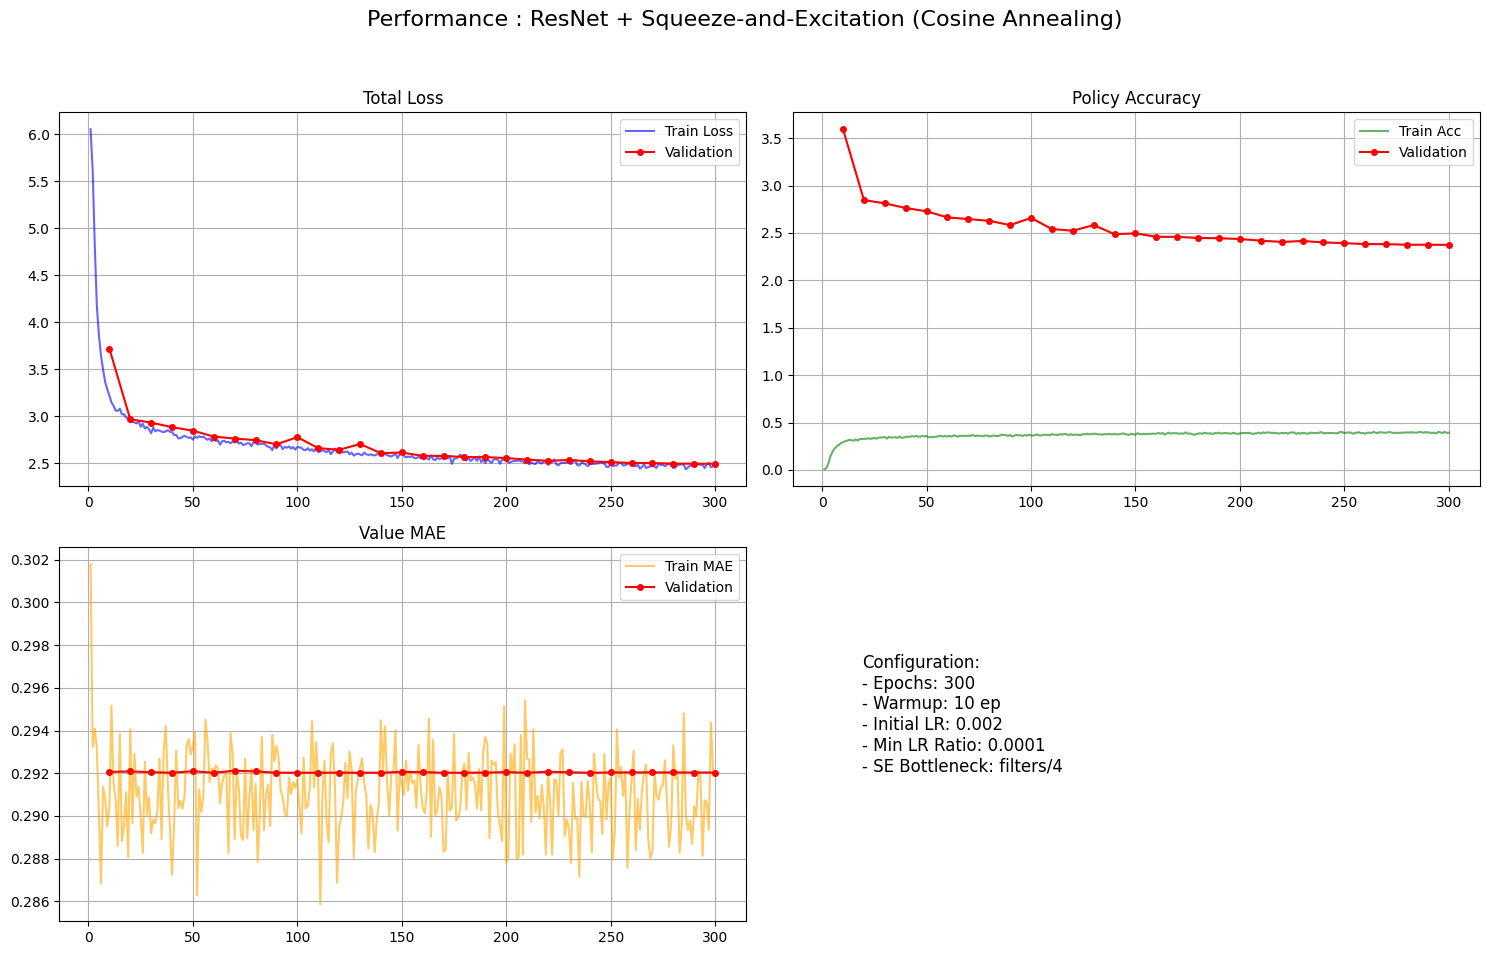

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
from tensorflow.keras import layers, regularizers, losses
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
import gc
import matplotlib.pyplot as plt
import golois

tf.keras.backend.clear_session(free_memory=True)

# --- Classe Learning Rate Schedule (Cosine Annealing + Warmup) ---
class CustomScheduleCA(LearningRateSchedule):
    def __init__(self, initial_learning_rate, decay_steps, alpha=0.0, name='CosineDecay', warmup_steps=0):
        super(CustomScheduleCA, self).__init__()
        self.initial_learning_rate = tf.cast(initial_learning_rate, tf.float32)
        self.decay_steps = tf.cast(decay_steps, tf.float32)
        self.alpha = tf.cast(alpha, tf.float32)
        self.warmup_steps = tf.cast(warmup_steps, tf.float32)
        self.name = name
        self.cosine_decay_schedule = tf.keras.optimizers.schedules.CosineDecay(
            initial_learning_rate=self.initial_learning_rate,
            decay_steps=self.decay_steps, alpha=self.alpha, name=self.name)

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        warmup_lr = self.initial_learning_rate * (step / self.warmup_steps)
        decay_lr = self.cosine_decay_schedule(step - self.warmup_steps)
        return tf.cond(tf.math.less(step, self.warmup_steps), lambda: warmup_lr, lambda: decay_lr)

    def get_config(self):
        return {'initial_learning_rate': float(self.initial_learning_rate.numpy()), 'decay_steps': int(self.decay_steps.numpy()), 'alpha': float(self.alpha.numpy()), 'name': self.name, 'warmup_steps': int(self.warmup_steps.numpy())}

# --- Paramètres ---
planes, moves, N, epochs, batch, filters = 31, 361, 10000, 300, 128, 32
N_val = 2000

# --- Séparation des données (Allocation Mémoire) ---
input_data = np.zeros((N, 19, 19, planes), dtype='float32')
policy = np.zeros((N, moves), dtype='float32')
value = np.zeros((N,), dtype='float32')
end = np.zeros((N, 19, 19, 2), dtype='float32')
groups = np.zeros((N, 19, 19, 1), dtype='float32')

val_input = np.zeros((N_val, 19, 19, planes), dtype='float32')
val_policy = np.zeros((N_val, moves), dtype='float32')
val_val = np.zeros((N_val,), dtype='float32')
val_end = np.zeros((N_val, 19, 19, 2), dtype='float32')

print("Chargement du set de validation séparé...")
golois.getValidation(val_input, val_policy, val_val, val_end)

# --- Architecture ---
input_layer = keras.Input(shape=(19, 19, planes), name='board')
x = layers.Conv2D(filters, 1, activation='relu', padding='same')(input_layer)

for i in range(4):
    ident = x
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([ident, x])
    x = layers.ReLU()(x)

# Bloc Squeeze-and-Excitation
se = layers.GlobalAveragePooling2D()(x)
se = layers.Dense(filters // 4, activation='relu')(se)
se = layers.Dense(filters, activation='sigmoid')(se)
se = layers.Reshape((1, 1, filters))(se)
x = layers.Multiply()([x, se])

policy_head = layers.Conv2D(1, 1, activation='relu', padding='same', use_bias=False, kernel_regularizer=regularizers.l2(0.0001))(x)
policy_head = layers.Flatten()(policy_head)
policy_head = layers.Activation('softmax', name='policy')(policy_head)

value_head = layers.Conv2D(1, 1, activation='relu', padding='same', use_bias=False, kernel_regularizer=regularizers.l2(0.0001))(x)
value_head = layers.Flatten()(value_head)
value_head = layers.Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(value_head)
value_head = layers.Dense(1, activation='sigmoid', name='value', kernel_regularizer=regularizers.l2(0.0001))(value_head)

model = keras.Model(inputs=input_layer, outputs=[policy_head, value_head])

# --- Compilation avec Schedule ---
steps_per_epoch = N // batch
lr_schedule = CustomScheduleCA(initial_learning_rate=0.002, decay_steps=steps_per_epoch*epochs, alpha=0.0001, warmup_steps=steps_per_epoch*10)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
              loss={'policy': 'categorical_crossentropy', 'value': 'mse'},
              metrics={'policy': 'categorical_accuracy', 'value': 'mae'})

# --- Historique pour Visualisation ---
history_data = {
    't_loss': [], 'v_loss': [],
    't_pol_acc': [], 'v_pol_acc': [],
    't_val_mae': [], 'v_val_mae': [],
    'v_epochs': []
}

# --- Boucle d'entraînement ---
for i in range(1, epochs + 1):
    print(f'Epoch {i}/{epochs}')
    golois.getBatch(input_data, policy, value, end, groups, i * N)

    h = model.fit(input_data, [policy, value], epochs=1, batch_size=batch, verbose=1)

    history_data['t_loss'].append(h.history['loss'][0])
    history_data['t_pol_acc'].append(h.history['policy_categorical_accuracy'][0])
    history_data['t_val_mae'].append(h.history['value_mae'][0])

    if i % 5 == 0: gc.collect()

    if i % 10 == 0: # Validation plus fréquente pour une courbe lisse
        val_res = model.evaluate(val_input, [val_policy, val_val], verbose=0, batch_size=batch)
        history_data['v_loss'].append(val_res[0])
        history_data['v_pol_acc'].append(val_res[1])
        history_data['v_val_mae'].append(val_res[4])
        history_data['v_epochs'].append(i)

# --- Génération des Graphiques ---
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Performance : ResNet + Squeeze-and-Excitation (Cosine Annealing)', fontsize=16)

# Styles de courbes identiques
def plot_style(ax, train, val, epochs_range, val_epochs, title, label_train, color):
    ax.plot(epochs_range, train, color=color, label=label_train, alpha=0.6)
    ax.plot(val_epochs, val, 'r-o', markersize=4, label='Validation')
    ax.set_title(title)
    ax.legend()
    ax.grid(True)

epochs_range = range(1, epochs + 1)

plot_style(axs[0, 0], history_data['t_loss'], history_data['v_loss'], epochs_range, history_data['v_epochs'], 'Total Loss', 'Train Loss', 'blue')
plot_style(axs[0, 1], history_data['t_pol_acc'], history_data['v_pol_acc'], epochs_range, history_data['v_epochs'], 'Policy Accuracy', 'Train Acc', 'green')
plot_style(axs[1, 0], history_data['t_val_mae'], history_data['v_val_mae'], epochs_range, history_data['v_epochs'], 'Value MAE', 'Train MAE', 'orange')

# Infos LR Schedule
axs[1, 1].axis('off')
axs[1, 1].text(0.1, 0.4, f"Configuration:\n- Epochs: {epochs}\n- Warmup: 10 ep\n- Initial LR: 0.002\n- Min LR Ratio: 0.0001\n- SE Bottleneck: filters/4", fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### reseaux residuels + attention en sortie (SE-post-block) sans cosine annealing


Chargement du set de validation séparé...
Epoch 1/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 67ms/step - loss: 6.0284 - policy_categorical_accuracy: 0.0031 - policy_loss: 5.8946 - value_loss: 0.1245 - value_mae: 0.2981
Epoch 2/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 6.0058 - policy_categorical_accuracy: 0.0044 - policy_loss: 5.8763 - value_loss: 0.1205 - value_mae: 0.2913
Epoch 3/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 5.8849 - policy_categorical_accuracy: 0.0145 - policy_loss: 5.7555 - value_loss: 0.1205 - value_mae: 0.2926
Epoch 4/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 5.4325 - policy_categorical_accuracy: 0.0374 - policy_loss: 5.3022 - value_loss: 0.1216 - value_mae: 0.2940
Epoch 5/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 5.0564 - policy_categorical_accuracy: 0.0675 - policy_loss: 4.9288 - value_loss: 0.1193 - value_mae: 0.2908
Epoch 6/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 4.8014 - policy_categorical_accuracy: 0.0819 - policy_los

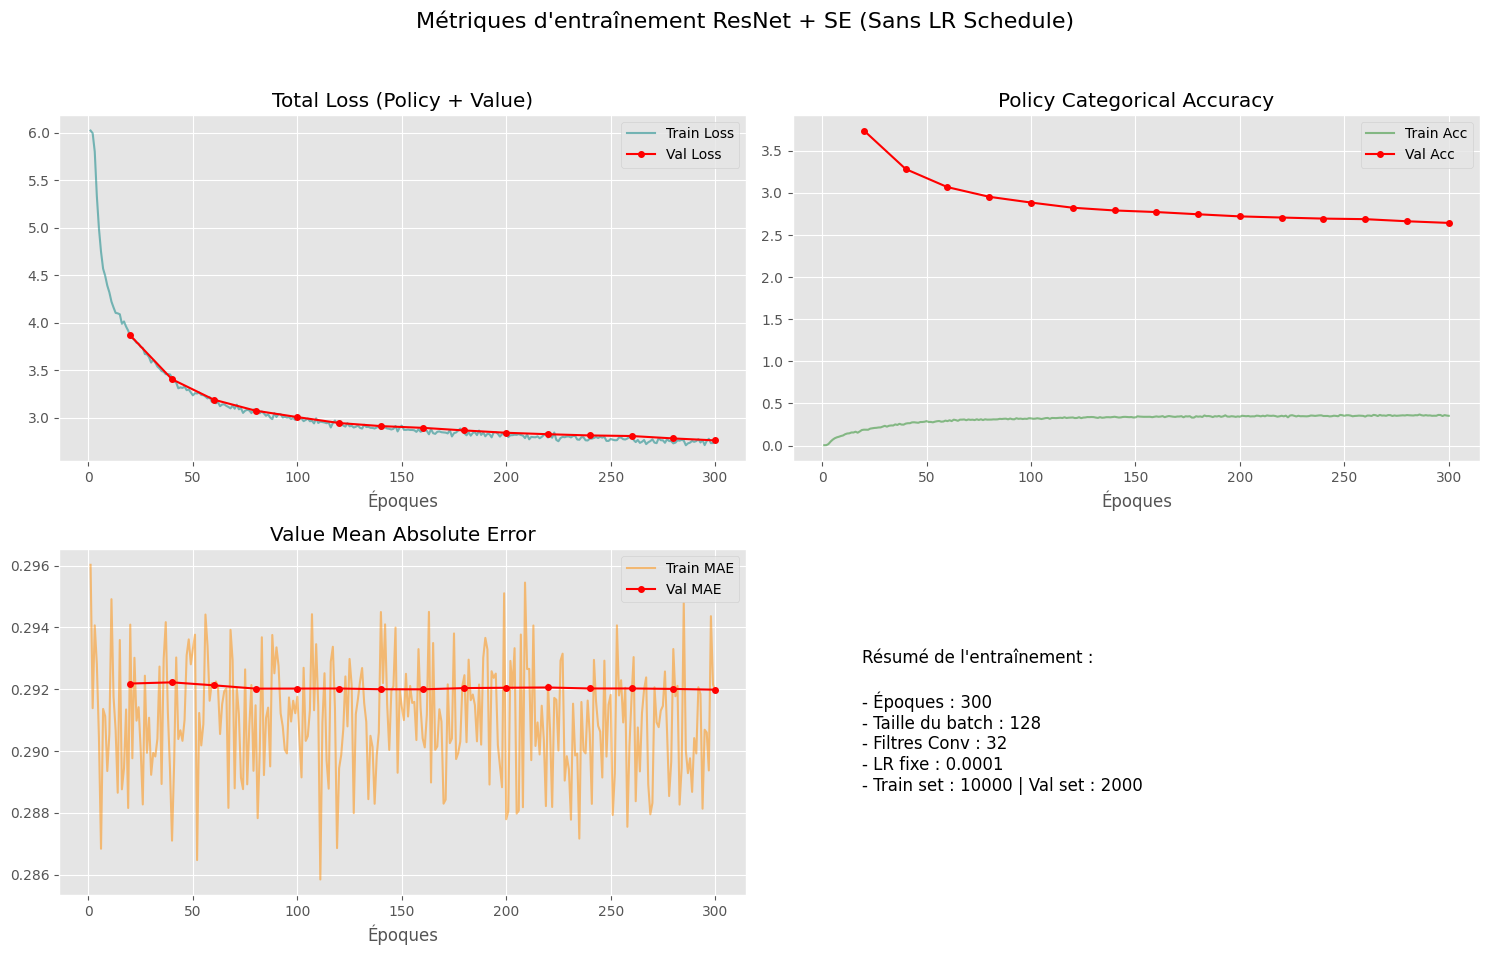

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
from tensorflow.keras import layers, regularizers, losses
import gc
import matplotlib.pyplot as plt
import golois

tf.keras.backend.clear_session(free_memory=True)

# --- Paramètres ---
planes, moves, N, epochs, batch, filters = 31, 361, 10000, 300, 128, 32
N_val = 2000  # Taille du set de validation distinct

# --- Préparation des données d'entraînement ---
input_data = np.zeros((N, 19, 19, planes), dtype='float32')
policy = np.zeros((N, moves), dtype='float32')
value = np.zeros((N,), dtype='float32')
end = np.zeros((N, 19, 19, 2), dtype='float32')
groups = np.zeros((N, 19, 19, 1), dtype='float32')

# --- Préparation des données de validation (SÉPARÉES) ---
val_input = np.zeros((N_val, 19, 19, planes), dtype='float32')
val_policy = np.zeros((N_val, moves), dtype='float32')
val_val = np.zeros((N_val,), dtype='float32')
val_end = np.zeros((N_val, 19, 19, 2), dtype='float32')

print("Chargement du set de validation séparé...")
golois.getValidation(val_input, val_policy, val_val, val_end)

# --- Architecture du Modèle ---
input_layer = keras.Input(shape=(19, 19, planes), name='board')
x = layers.Conv2D(filters, 1, activation='relu', padding='same')(input_layer)

for i in range(4):
    ident = x
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([ident, x])
    x = layers.ReLU()(x)

se = layers.GlobalAveragePooling2D()(x)
se = layers.Dense(filters // 4, activation='relu')(se)
se = layers.Dense(filters, activation='sigmoid')(se)
se = layers.Reshape((1, 1, filters))(se)
x = layers.Multiply()([x, se])

policy_head = layers.Conv2D(1, 1, activation='relu', padding='same', use_bias=False,
                            kernel_regularizer=regularizers.l2(0.0001))(x)
policy_head = layers.Flatten()(policy_head)
policy_head = layers.Activation('softmax', name='policy')(policy_head)

value_head = layers.Conv2D(1, 1, activation='relu', padding='same', use_bias=False,
                           kernel_regularizer=regularizers.l2(0.0001))(x)
value_head = layers.Flatten()(value_head)
value_head = layers.Dense(50, activation='relu',
                          kernel_regularizer=regularizers.l2(0.0001))(value_head)
value_head = layers.Dense(1, activation='sigmoid', name='value',
                          kernel_regularizer=regularizers.l2(0.0001))(value_head)

model = keras.Model(inputs=input_layer, outputs=[policy_head, value_head])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss={'policy': 'categorical_crossentropy', 'value': 'mse'},
    metrics={'policy': 'categorical_accuracy', 'value': 'mae'}
)

# --- Historique pour toutes les métriques ---
history_data = {
    'train_loss': [], 'val_loss': [],
    'train_pol_acc': [], 'val_pol_acc': [],
    'train_val_mae': [], 'val_val_mae': [],
    'val_epochs': []
}

# --- Boucle d'entraînement ---
for i in range(1, epochs + 1):
    print(f'Epoch {i}/{epochs}')
    golois.getBatch(input_data, policy, value, end, groups, i * N)

    h = model.fit(input_data, [policy, value], epochs=1, batch_size=batch, verbose=1)

    # Stockage entraînement
    history_data['train_loss'].append(h.history['loss'][0])
    history_data['train_pol_acc'].append(h.history['policy_categorical_accuracy'][0])
    history_data['train_val_mae'].append(h.history['value_mae'][0])

    if i % 5 == 0: gc.collect()

    # Validation périodique (tous les 20 pour un graphique plus détaillé)
    if i % 20 == 0:
        val_res = model.evaluate(val_input, [val_policy, val_val], verbose=0, batch_size=batch)
        history_data['val_loss'].append(val_res[0])
        history_data['val_pol_acc'].append(val_res[1]) # Index 1 : policy accuracy
        history_data['val_val_mae'].append(val_res[4]) # Index 4 : value MAE
        history_data['val_epochs'].append(i)

        print(f"--- Validation Epoch {i} : Loss {val_res[0]:.4f} | Acc {val_res[1]:.4f}")

# --- Visualisation Grille 2x2 ---
plt.style.use('ggplot')
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Métriques d\'entraînement ResNet + SE (Sans LR Schedule)', fontsize=16)

# Fonction pour uniformiser le style des tracés
def plot_metric(ax, train_data, val_data, val_epochs, title, color, label_prefix):
    ax.plot(range(1, epochs + 1), train_data, color=color, label=f'Train {label_prefix}', alpha=0.5)
    ax.plot(val_epochs, val_data, color='red', marker='o', linestyle='-', markersize=4, label=f'Val {label_prefix}')
    ax.set_title(title)
    ax.set_xlabel('Époques')
    ax.legend()
    ax.grid(True)

# 1. Total Loss
plot_metric(axs[0, 0], history_data['train_loss'], history_data['val_loss'],
            history_data['val_epochs'], 'Total Loss (Policy + Value)', 'teal', 'Loss')

# 2. Policy Categorical Accuracy
plot_metric(axs[0, 1], history_data['train_pol_acc'], history_data['val_pol_acc'],
            history_data['val_epochs'], 'Policy Categorical Accuracy', 'forestgreen', 'Acc')

# 3. Value Mean Absolute Error (MAE)
plot_metric(axs[1, 0], history_data['train_val_mae'], history_data['val_val_mae'],
            history_data['val_epochs'], 'Value Mean Absolute Error', 'darkorange', 'MAE')

# 4. Légende / Résumé
axs[1, 1].axis('off')
axs[1, 1].text(0.1, 0.5, (f"Résumé de l'entraînement :\n\n"
                          f"- Époques : {epochs}\n"
                          f"- Taille du batch : {batch}\n"
                          f"- Filtres Conv : {filters}\n"
                          f"- LR fixe : 0.0001\n"
                          f"- Train set : {N} | Val set : {N_val}"), fontsize=12, verticalalignment='center')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

model.save('model_resnet_se_final.h5')

### reseaux residuels + attention en sortie (SE-post-block) Avec distillation

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
from tensorflow.keras import layers, regularizers, losses
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
import gc
import matplotlib.pyplot as plt
import golois

tf.keras.backend.clear_session(free_memory=True)

# ============================================
# 1. ARCHITECTURE ET UTILS
# ============================================
def create_go_model(filters, num_blocks, name="go_model"):
    input_layer = keras.Input(shape=(19, 19, 31), name='board')
    x = layers.Conv2D(filters, 1, activation='relu', padding='same')(input_layer)

    for i in range(num_blocks):
        ident = x
        x = layers.Conv2D(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2D(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.add([ident, x])
        x = layers.ReLU()(x)

    se = layers.GlobalAveragePooling2D()(x)
    se = layers.Dense(filters // 4, activation='relu')(se)
    se = layers.Dense(filters, activation='sigmoid')(se)
    se = layers.Reshape((1, 1, filters))(se)
    x = layers.Multiply()([x, se])

    p_head = layers.Conv2D(1, 1, activation='relu', padding='same', use_bias=False)(x)
    p_head = layers.Flatten()(p_head)
    p_head = layers.Activation('softmax', name='policy')(p_head)

    v_head = layers.Conv2D(1, 1, activation='relu', padding='same', use_bias=False)(x)
    v_head = layers.Flatten()(v_head)
    v_head = layers.Dense(50, activation='relu')(v_head)
    v_head = layers.Dense(1, activation='sigmoid', name='value')(v_head)

    return keras.Model(inputs=input_layer, outputs=[p_head, v_head], name=name)

# ============================================
# 2. CLASSE DE DISTILLATION CORRIGÉE
# ============================================
class Distiller(keras.Model):
    def __init__(self, student, teacher, temperature=3.0, alpha=0.3):
        super(Distiller, self).__init__()
        self.student = student
        self.teacher = teacher
        self.temperature = temperature
        self.alpha = alpha

    def compile(self, optimizer, metrics, loss_weights):
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.loss_weights = loss_weights
        self.policy_loss_fn = losses.CategoricalCrossentropy()
        self.value_loss_fn = losses.MeanSquaredError()
        self.distillation_loss_fn = losses.KLDivergence()

    def train_step(self, data):
        x, y = data
        y_policy, y_value = y

        t_pol, t_val = self.teacher(x, training=False)
        t_pol_soft = tf.nn.softmax(tf.math.log(t_pol + 1e-10) / self.temperature)

        with tf.GradientTape() as tape:
            s_pol, s_val = self.student(x, training=True)

            p_loss_hard = self.policy_loss_fn(y_policy, s_pol)
            v_loss_hard = self.value_loss_fn(y_value, s_val)

            s_pol_soft = tf.nn.softmax(tf.math.log(s_pol + 1e-10) / self.temperature)
            distill_p = self.distillation_loss_fn(t_pol_soft, s_pol_soft) * (self.temperature ** 2)
            distill_v = tf.reduce_mean(tf.square(t_val - s_val))

            total_p = (1 - self.alpha) * p_loss_hard + self.alpha * distill_p
            total_v = (1 - self.alpha) * v_loss_hard + self.alpha * distill_v

            total_loss = (self.loss_weights['policy'] * total_p + self.loss_weights['value'] * total_v)
            total_loss += sum(self.student.losses)

        grads = tape.gradient(total_loss, self.student.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.student.trainable_variables))

        # --- CORRECTION ICI : update_state AVANT result() ---
        for m in self.metrics:
            if 'policy' in m.name:
                m.update_state(y_policy, s_pol)
            elif 'value' in m.name:
                m.update_state(y_value, s_val)

        results = {m.name: m.result() for m in self.metrics}
        results.update({"loss": total_loss})
        return results

    def test_step(self, data):
        x, y = data
        y_policy, y_value = y
        preds = self.student(x, training=False)
        for m in self.metrics:
            if 'policy' in m.name: m.update_state(y_policy, preds[0])
            elif 'value' in m.name: m.update_state(y_value, preds[1])
        return {m.name: m.result() for m in self.metrics}

# ============================================
# 3. BOUCLE D'ENTRAÎNEMENT ET VISUALISATION
# ============================================
N, N_val, epochs_t, epochs_s, batch = 10000, 2000, 150, 300, 128
input_data = np.zeros((N, 19, 19, 31), dtype='float32')
policy = np.zeros((N, 361), dtype='float32')
value, end, groups = np.zeros((N,), dtype='float32'), np.zeros((N, 19, 19, 2), dtype='float32'), np.zeros((N, 19, 19, 1), dtype='float32')

val_in = np.zeros((N_val, 19, 19, 31), dtype='float32')
val_pol = np.zeros((N_val, 361), dtype='float32')
val_v = np.zeros((N_val,), dtype='float32')
val_e = np.zeros((N_val, 19, 19, 2), dtype='float32')

golois.getValidation(val_in, val_pol, val_v, val_e)

# --- Phase Teacher ---
teacher = create_go_model(64, 6, "teacher")
teacher.compile(optimizer='adam', loss={'policy': 'categorical_crossentropy', 'value': 'mse'},
                metrics={'policy': 'categorical_accuracy', 'value': 'mae'})

t_hist = {'loss': [], 'acc': [], 'val_acc': [], 'val_epochs': []}

for i in range(1, epochs_t + 1):
    golois.getBatch(input_data, policy, value, end, groups, i * N)
    h = teacher.fit(input_data, [policy, value], epochs=1, batch_size=batch, verbose=1)
    t_hist['loss'].append(h.history['loss'][0])
    t_hist['acc'].append(h.history['policy_categorical_accuracy'][0])
    if i % 20 == 0:
        r = teacher.evaluate(val_in, [val_pol, val_v], verbose=0)
        t_hist['val_acc'].append(r[1])
        t_hist['val_epochs'].append(i)

# --- Phase Student ---
student = create_go_model(32, 4, "student")
distiller = Distiller(student, teacher, alpha=0.3)
distiller.compile(optimizer='adam',
                  metrics={'policy': metrics.CategoricalAccuracy(name='policy_acc'),
                           'value': metrics.MeanAbsoluteError(name='value_mae')},
                  loss_weights={'policy': 1.0, 'value': 1.0})

s_hist = {'loss': [], 'acc': [], 'val_acc': [], 'val_epochs': []}

for i in range(1, epochs_s + 1):
    golois.getBatch(input_data, policy, value, end, groups, i * N)
    h = distiller.fit(input_data, [policy, value], epochs=1, batch_size=batch, verbose=1)

    # Correction de l'accès aux clés du dictionnaire history
    s_hist['loss'].append(h.history['loss'][0])
    s_hist['acc'].append(h.history['policy_acc'][0])

    if i % 20 == 0:
        r = distiller.evaluate(val_in, [val_pol, val_v], verbose=0)
        s_hist['val_acc'].append(r[0]) # r[0] car evaluate renvoie [policy_acc, value_mae]
        s_hist['val_epochs'].append(i)

# --- Visualisation ---

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(t_hist['loss'], label='Teacher Train', alpha=0.3)
axs[0].plot(s_hist['loss'], label='Student Distill', color='green')
axs[0].set_title('Pertes (Loss)'); axs[0].legend()

axs[1].plot(t_hist['val_epochs'], t_hist['val_acc'], 'b--o', label='Teacher Val')
axs[1].plot(s_hist['val_epochs'], s_hist['val_acc'], 'r-o', label='Student Val')
axs[1].set_title('Précision (Policy Accuracy)'); axs[1].legend()
plt.show()

79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 114ms/step - loss: 5.7970 - policy_categorical_accuracy: 0.0165 - policy_loss: 5.6710 - value_loss: 0.1256 - value_mae: 0.2984
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 4.0198 - policy_categorical_accuracy: 0.1665 - policy_loss: 3.9019 - value_loss: 0.1178 - value_mae: 0.2879
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 3.6536 - policy_categorical_accuracy: 0.2231 - policy_loss: 3.5313 - value_loss: 0.1220 - value_mae: 0.2965
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 3.3582 - policy_categorical_accuracy: 0.2634 - policy_loss: 3.2375 - value_loss: 0.1207 - value_mae: 0.2938
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 3.2508 - policy_categorical_accuracy: 0.2840 - policy_loss: 3.1307 - value_loss: 0.1203 - value_mae: 0.2929
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 3.2336 - policy_categorical_accuracy: 0.2856 - policy_loss: 3.1154 - value_loss: 0.1182 - value_mae: 0.2884
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 3.1501 - polic

NameError: name 'metrics' is not defined